In [1]:
!nrnivmodl "../nrn"

/nfs/pool0/mikesomm/STATS220-FINAL-PROJECT/src
Mod files: "../nrn/../nrn/capump.mod" "../nrn/../nrn/ingauss.mod" "../nrn/../nrn/mammalian_spike_35.mod" "../nrn/../nrn/mammalian_spike.mod" "../nrn/../nrn/xtra.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [2]:
from neuron import h
from hoc2swc import neuron2swc
import jaxley as jx

import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt
from IPython.display import HTML

import functions_neuron as fn
import functions_jaxley as fj
import functions_helper as fh
from constants import LITKE_519_ARRAY_MAP

--No graphics will be displayed.


In [3]:
for sec in h.allsec():
   h.delete_section(sec=sec)
RGC = fn.Local_Cell()
RGC.build_cell("params_35_v2.csv", "mammalian_spike_35")
RGC.section_list

After any change to cell geometry or nseg, be sure to invoke setpointers()
[[-0.01194     0.          0.02      ]
 [-0.01227408  0.          0.02094255]
 [-0.01275496  0.          0.02181933]
 ...
 [-3.05527043  0.          0.03994091]
 [-3.05627043  0.          0.03994091]
 [-3.05727043  0.          0.03994091]]
[  -11.94         -12.27407655   -12.75496473 ... -3055.27042625
 -3056.27042625 -3057.27042625]


[Cell[0].soma,
 Cell[0].dend[0],
 Cell[0].dend[50],
 Cell[0].dend[52],
 Cell[0].dend[54],
 Cell[0].dend[78],
 Cell[0].dend[80],
 Cell[0].dend[79],
 Cell[0].dend[55],
 Cell[0].dend[69],
 Cell[0].dend[75],
 Cell[0].dend[77],
 Cell[0].dend[76],
 Cell[0].dend[70],
 Cell[0].dend[74],
 Cell[0].dend[71],
 Cell[0].dend[73],
 Cell[0].dend[72],
 Cell[0].dend[56],
 Cell[0].dend[66],
 Cell[0].dend[68],
 Cell[0].dend[67],
 Cell[0].dend[57],
 Cell[0].dend[61],
 Cell[0].dend[63],
 Cell[0].dend[65],
 Cell[0].dend[64],
 Cell[0].dend[62],
 Cell[0].dend[58],
 Cell[0].dend[60],
 Cell[0].dend[59],
 Cell[0].dend[53],
 Cell[0].dend[51],
 Cell[0].dend[1],
 Cell[0].dend[45],
 Cell[0].dend[49],
 Cell[0].dend[46],
 Cell[0].dend[48],
 Cell[0].dend[47],
 Cell[0].dend[2],
 Cell[0].dend[28],
 Cell[0].dend[42],
 Cell[0].dend[44],
 Cell[0].dend[43],
 Cell[0].dend[29],
 Cell[0].dend[41],
 Cell[0].dend[30],
 Cell[0].dend[36],
 Cell[0].dend[38],
 Cell[0].dend[40],
 Cell[0].dend[39],
 Cell[0].dend[37],
 Cell[0].dend[31],


In [4]:
# Save the number of segments and indices of branches
sec_lu = np.zeros((len(RGC.section_list), 2))
for i in range(len(RGC.section_list)):
  if "soma" in str(RGC.section_list[i]):
    sec_lu[i, 0] = 0
  elif "dend" in str(RGC.section_list[i]):
    sec_lu[i, 0] = 1
  elif "AH" in str(RGC.section_list[i]):
    sec_lu[i, 0] = 2
  elif "SOCB" in str(RGC.section_list[i]):
    sec_lu[i, 0] = 3
  elif "NR" in str(RGC.section_list[i]):
    sec_lu[i, 0] = 4
  elif "axon" in str(RGC.section_list[i]):
    sec_lu[i, 0] = 5
  else:
    print("Error: Section not found")
  sec_lu[i, 1] = RGC.section_list[i].nseg

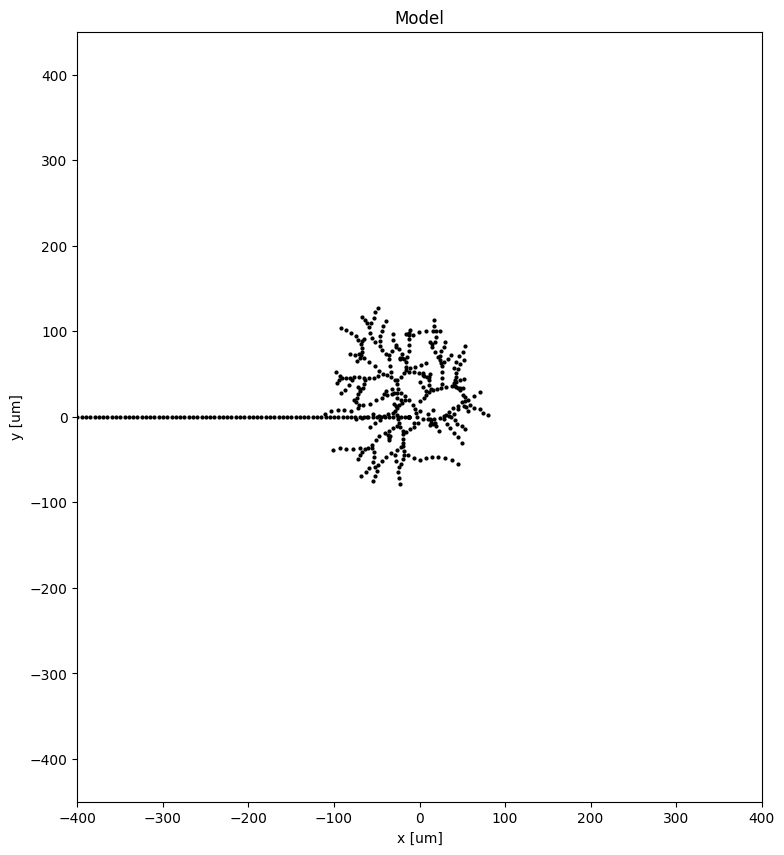

In [5]:
# plot electrode array using plt
fig = plt.figure(figsize=(20,10))

# side by side subplots

ax = fig.add_subplot(121)

for sec in RGC.section_list:
    for seg in sec:
        ax.plot(seg.x_xtra,seg.y_xtra,'o',color='black',markersize=2)

ax.set_aspect('equal')
ax.set_xlim([-400,400])
ax.set_ylim([-450,450])
# ax2.set_aspect('equal')
ax.set_title('Model')
# ax2.set_title('Real')
ax.set_xlabel('x [um]')
ax.set_ylabel('y [um]')
# ax2.set_xlabel('x [um]')
# ax2.set_ylabel('y [um]')
plt.show()

In [6]:
neuron2swc("RGC_morph_4.swc")

Wrote cell 0 to RGC_morph_4.swc


In [7]:
fname = "RGC_morph_4.swc"
cell = jx.read_swc(fname, ncomp=1, min_radius=0, assign_groups=False, backend="custom")
cell.show()

/pool0/mikesomm/mike_env_10/lib/python3.10/site-packages/jaxley/io/swc.py:478: UserWarning: You set `jx.read_swc(..., backend='custom')`. The `custom` option is deprecated and will be removed in `Jaxley` version `0.10.0`. Use `jx.read_swc(..., backend='graph')` instead. If you are experiencing issues with this SWC reader, please open a `New issue` on GitHub: https://github.com/jaxleyverse/jaxley/issues
  warn(


,local_comp_index,global_comp_index,local_branch_index,global_branch_index,local_cell_index,global_cell_index
0,0,0,0,0,0,0
1,0,1,1,1,0,0
2,0,2,2,2,0,0
3,0,3,3,3,0,0
4,0,4,4,4,0,0
...,...,...,...,...,...,...
119,0,119,119,119,0,0
120,0,120,120,120,0,0
121,0,121,121,121,0,0
122,0,122,122,122,0,0


In [8]:
cell._branchpoints
cell._comp_edges

,source,sink,type
0,124,0,1
1,125,1,1
2,126,2,1
3,127,3,1
4,128,4,1
...,...,...,...
365,119,185,4
366,120,185,4
367,121,177,4
368,122,177,4


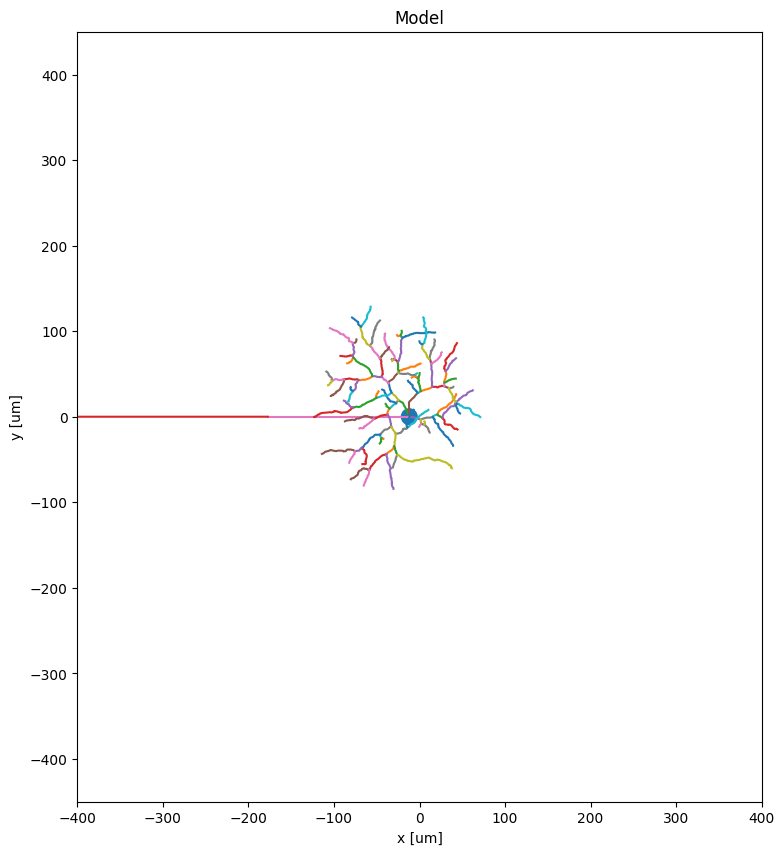

In [9]:
# plot electrode array using plt
fig = plt.figure(figsize=(20,10))

# side by side subplots

ax = fig.add_subplot(121)

# define colorwheel with 10 colors
colors = plt.cm.tab10.colors
for i, branch in enumerate(cell.branches):
    branch.vis(ax=ax, color=colors[i % 10])
ax.set_aspect('equal')
ax.set_xlim([-400,400])
ax.set_ylim([-450,450])
# ax2.set_aspect('equal')
ax.set_title('Model')
# ax2.set_title('Real')
ax.set_xlabel('x [um]')
ax.set_ylabel('y [um]')
# ax2.set_xlabel('x [um]')
# ax2.set_ylabel('y [um]')
plt.show()

In [10]:
cell.compute_compartment_centers()
cell.initialize()
cell.nodes.T

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
local_cell_index,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
local_branch_index,0.00,1.00,2.000000,3.00,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,114.000000,115.000000,116.000000,117.000000,118.000000,119.000000,120.000000,121.000000,122.000000,123.000000
local_comp_index,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
length,0.10,10.00,31.056230,10.00,15.992602,32.705717,169.999747,4.343017,12.167121,9.935438,...,20.053614,7.171415,19.965529,27.321897,22.303228,36.456505,5.150790,9.131475,6.196205,2880.001000
radius,10.00,10.00,4.245134,10.00,4.344984,3.410932,1.191178,4.307500,4.750266,2.922093,...,0.306027,0.396936,0.228993,0.399241,0.495454,0.453865,0.823676,0.347807,0.186517,0.750000
axial_resistivity,5000.00,5000.00,5000.000000,5000.00,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
capacitance,1.00,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
v,-70.00,-70.00,-70.000000,-70.00,-70.000000,-70.000000,-70.000000,-70.000000,-70.000000,-70.000000,...,-70.000000,-70.000000,-70.000000,-70.000000,-70.000000,-70.000000,-70.000000,-70.000000,-70.000000,-70.000000
x,-11.94,-11.94,-18.400000,-11.94,-5.220000,-7.130000,-94.605003,-26.125000,-28.800001,-31.215000,...,36.544998,12.815001,20.025000,14.469999,7.400000,3.820000,1.585000,-5.230000,-0.670000,-1617.270508
y,0.00,0.00,9.665000,0.00,-1.705000,13.875000,0.000000,17.565001,23.779999,12.735001,...,61.029999,64.970001,68.695000,79.000000,76.309998,100.410004,86.459999,45.490002,48.169998,0.000000


In [11]:
assert len(cell.nodes) == len(sec_lu)
for i in range(len(cell.nodes)):
  if sec_lu[i, 0] == 0:
    cell.branch(i).add_to_group("soma")
  elif sec_lu[i, 0] == 1:
    cell.branch(i).add_to_group("dend")
  elif sec_lu[i, 0] == 2:
    cell.branch(i).add_to_group("AH")
  elif sec_lu[i, 0] == 3:
    cell.branch(i).add_to_group("SOCB")
  elif sec_lu[i, 0] == 4:
    cell.branch(i).add_to_group("NR")
  elif sec_lu[i, 0] == 5:
    cell.branch(i).add_to_group("axon")
  else:
    print("Error: Section not found")
  cell.branch(i).set_ncomp(int(sec_lu[i, 1]))

In [12]:
cell.compute_compartment_centers()
cell.initialize()
cell.nodes.T

,0,1,2,3,4,5,6,7,8,9,...,949,950,951,952,953,954,955,956,957,958
local_cell_index,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
local_branch_index,0,0,0,0,0,1,1,1,1,2,...,123,123,123,123,123,123,123,123,123,123
local_comp_index,0,1,2,3,4,0,1,2,3,0,...,566,567,568,569,570,571,572,573,574,575
length,0.02,0.02,0.02,0.02,0.02,2.5,2.5,2.5,2.5,31.05623,...,5.000002,5.000002,5.000002,5.000002,5.000002,5.000002,5.000002,5.000002,5.000002,5.000002
radius,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,4.245134,...,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
axial_resistivity,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
capacitance,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
v,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,...,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0
x,-11.94,-11.94,-11.94,-11.94,-11.94,-11.94,-11.94,-11.94,-11.94,-18.4,...,-3009.770996,-3014.770996,-3019.770996,-3024.770996,-3029.770996,-3034.770996,-3039.770996,-3044.770996,-3049.770996,-3054.770996
y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
cell.insert(fj.HH())
cell.insert(fj.Ca())
cell.insert(fj.CaPump())
cell.insert(fj.CaNernstReversal())
cell.insert(fj.KCa())

In [14]:
cell.initialize()
cell.nodes.T

,0,1,2,3,4,5,6,7,8,9,...,949,950,951,952,953,954,955,956,957,958
local_cell_index,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
local_branch_index,0,0,0,0,0,1,1,1,1,2,...,123,123,123,123,123,123,123,123,123,123
local_comp_index,0,1,2,3,4,0,1,2,3,0,...,566,567,568,569,570,571,572,573,574,575
length,0.02,0.02,0.02,0.02,0.02,2.5,2.5,2.5,2.5,31.05623,...,5.000002,5.000002,5.000002,5.000002,5.000002,5.000002,5.000002,5.000002,5.000002,5.000002
radius,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,4.245134,...,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
axial_resistivity,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
capacitance,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
v,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,...,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0,-70.0
x,-11.94,-11.94,-11.94,-11.94,-11.94,-11.94,-11.94,-11.94,-11.94,-18.4,...,-3009.770996,-3014.770996,-3019.770996,-3024.770996,-3029.770996,-3034.770996,-3039.770996,-3044.770996,-3049.770996,-3054.770996
y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
### general parameters
cell.set("HH_eNa",60.6)
cell.set("HH_eK",-101.34)
cell.set("HH_eLeak",-64.58)
cell.set('axial_resistivity', 143.2)
cell.set("v",-65.02069782)

In [16]:
### Assign conductances

### Soma
cell.soma.set('HH_gLeak',0.0001)
cell.soma.set('HH_gNa',0.06)
cell.soma.set('HH_gK',0.035)
cell.soma.set('gCa',0.00075)
cell.soma.set('gKCa',0.00017)

### Dendrite
cell.dend.set('HH_gLeak',0.0001)
cell.dend.set('HH_gNa',0.06)
cell.dend.set('HH_gK',0.035)
cell.dend.set('gCa',0.001)
cell.dend.set('gKCa',0.00017)

### Axon Hillock
cell.AH.set('HH_gLeak',0.0001)
cell.AH.set('HH_gNa',0.15)
cell.AH.set('HH_gK',0.09)
cell.AH.set('gCa',0.00075)
cell.AH.set('gKCa',0.00017)

### Sodium Channel Band
cell.SOCB.set('HH_gLeak',0.0001)
cell.SOCB.set('HH_gNa',0.42)
cell.SOCB.set('HH_gK',0.25)
cell.SOCB.set('gCa',0.00075)
cell.SOCB.set('gKCa',0.00011)

### Narrow Axon
cell.NR.set('HH_gLeak',0.0001)
cell.NR.set('HH_gNa',0.1)
cell.NR.set('HH_gK',0.05)
cell.NR.set('gCa',0.00075)
cell.NR.set('gKCa',0.0002)

### Distal Axon
cell.dend.set('HH_gLeak',0.0001)
cell.dend.set('HH_gNa',0.1)
cell.dend.set('HH_gK',0.05)
cell.dend.set('gCa',0.00075)
cell.dend.set('gKCa',0.0002)

In [17]:
cell.initialize()
cell.init_states()
ncomps = cell.shape[1]
cell.nodes.T

,0,1,2,3,4,5,6,7,8,9,...,949,950,951,952,953,954,955,956,957,958
local_cell_index,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
local_branch_index,0,0,0,0,0,1,1,1,1,2,...,123,123,123,123,123,123,123,123,123,123
local_comp_index,0,1,2,3,4,0,1,2,3,0,...,566,567,568,569,570,571,572,573,574,575
length,0.02,0.02,0.02,0.02,0.02,2.5,2.5,2.5,2.5,31.05623,...,5.000002,5.000002,5.000002,5.000002,5.000002,5.000002,5.000002,5.000002,5.000002,5.000002
radius,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,4.245134,...,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
axial_resistivity,143.2,143.2,143.2,143.2,143.2,143.2,143.2,143.2,143.2,143.2,...,143.2,143.2,143.2,143.2,143.2,143.2,143.2,143.2,143.2,143.2
capacitance,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
v,-65.020698,-65.020698,-65.020698,-65.020698,-65.020698,-65.020698,-65.020698,-65.020698,-65.020698,-65.020698,...,-65.020698,-65.020698,-65.020698,-65.020698,-65.020698,-65.020698,-65.020698,-65.020698,-65.020698,-65.020698
x,-11.94,-11.94,-11.94,-11.94,-11.94,-11.94,-11.94,-11.94,-11.94,-18.4,...,-3009.770996,-3014.770996,-3019.770996,-3024.770996,-3029.770996,-3034.770996,-3039.770996,-3044.770996,-3049.770996,-3054.770996
y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


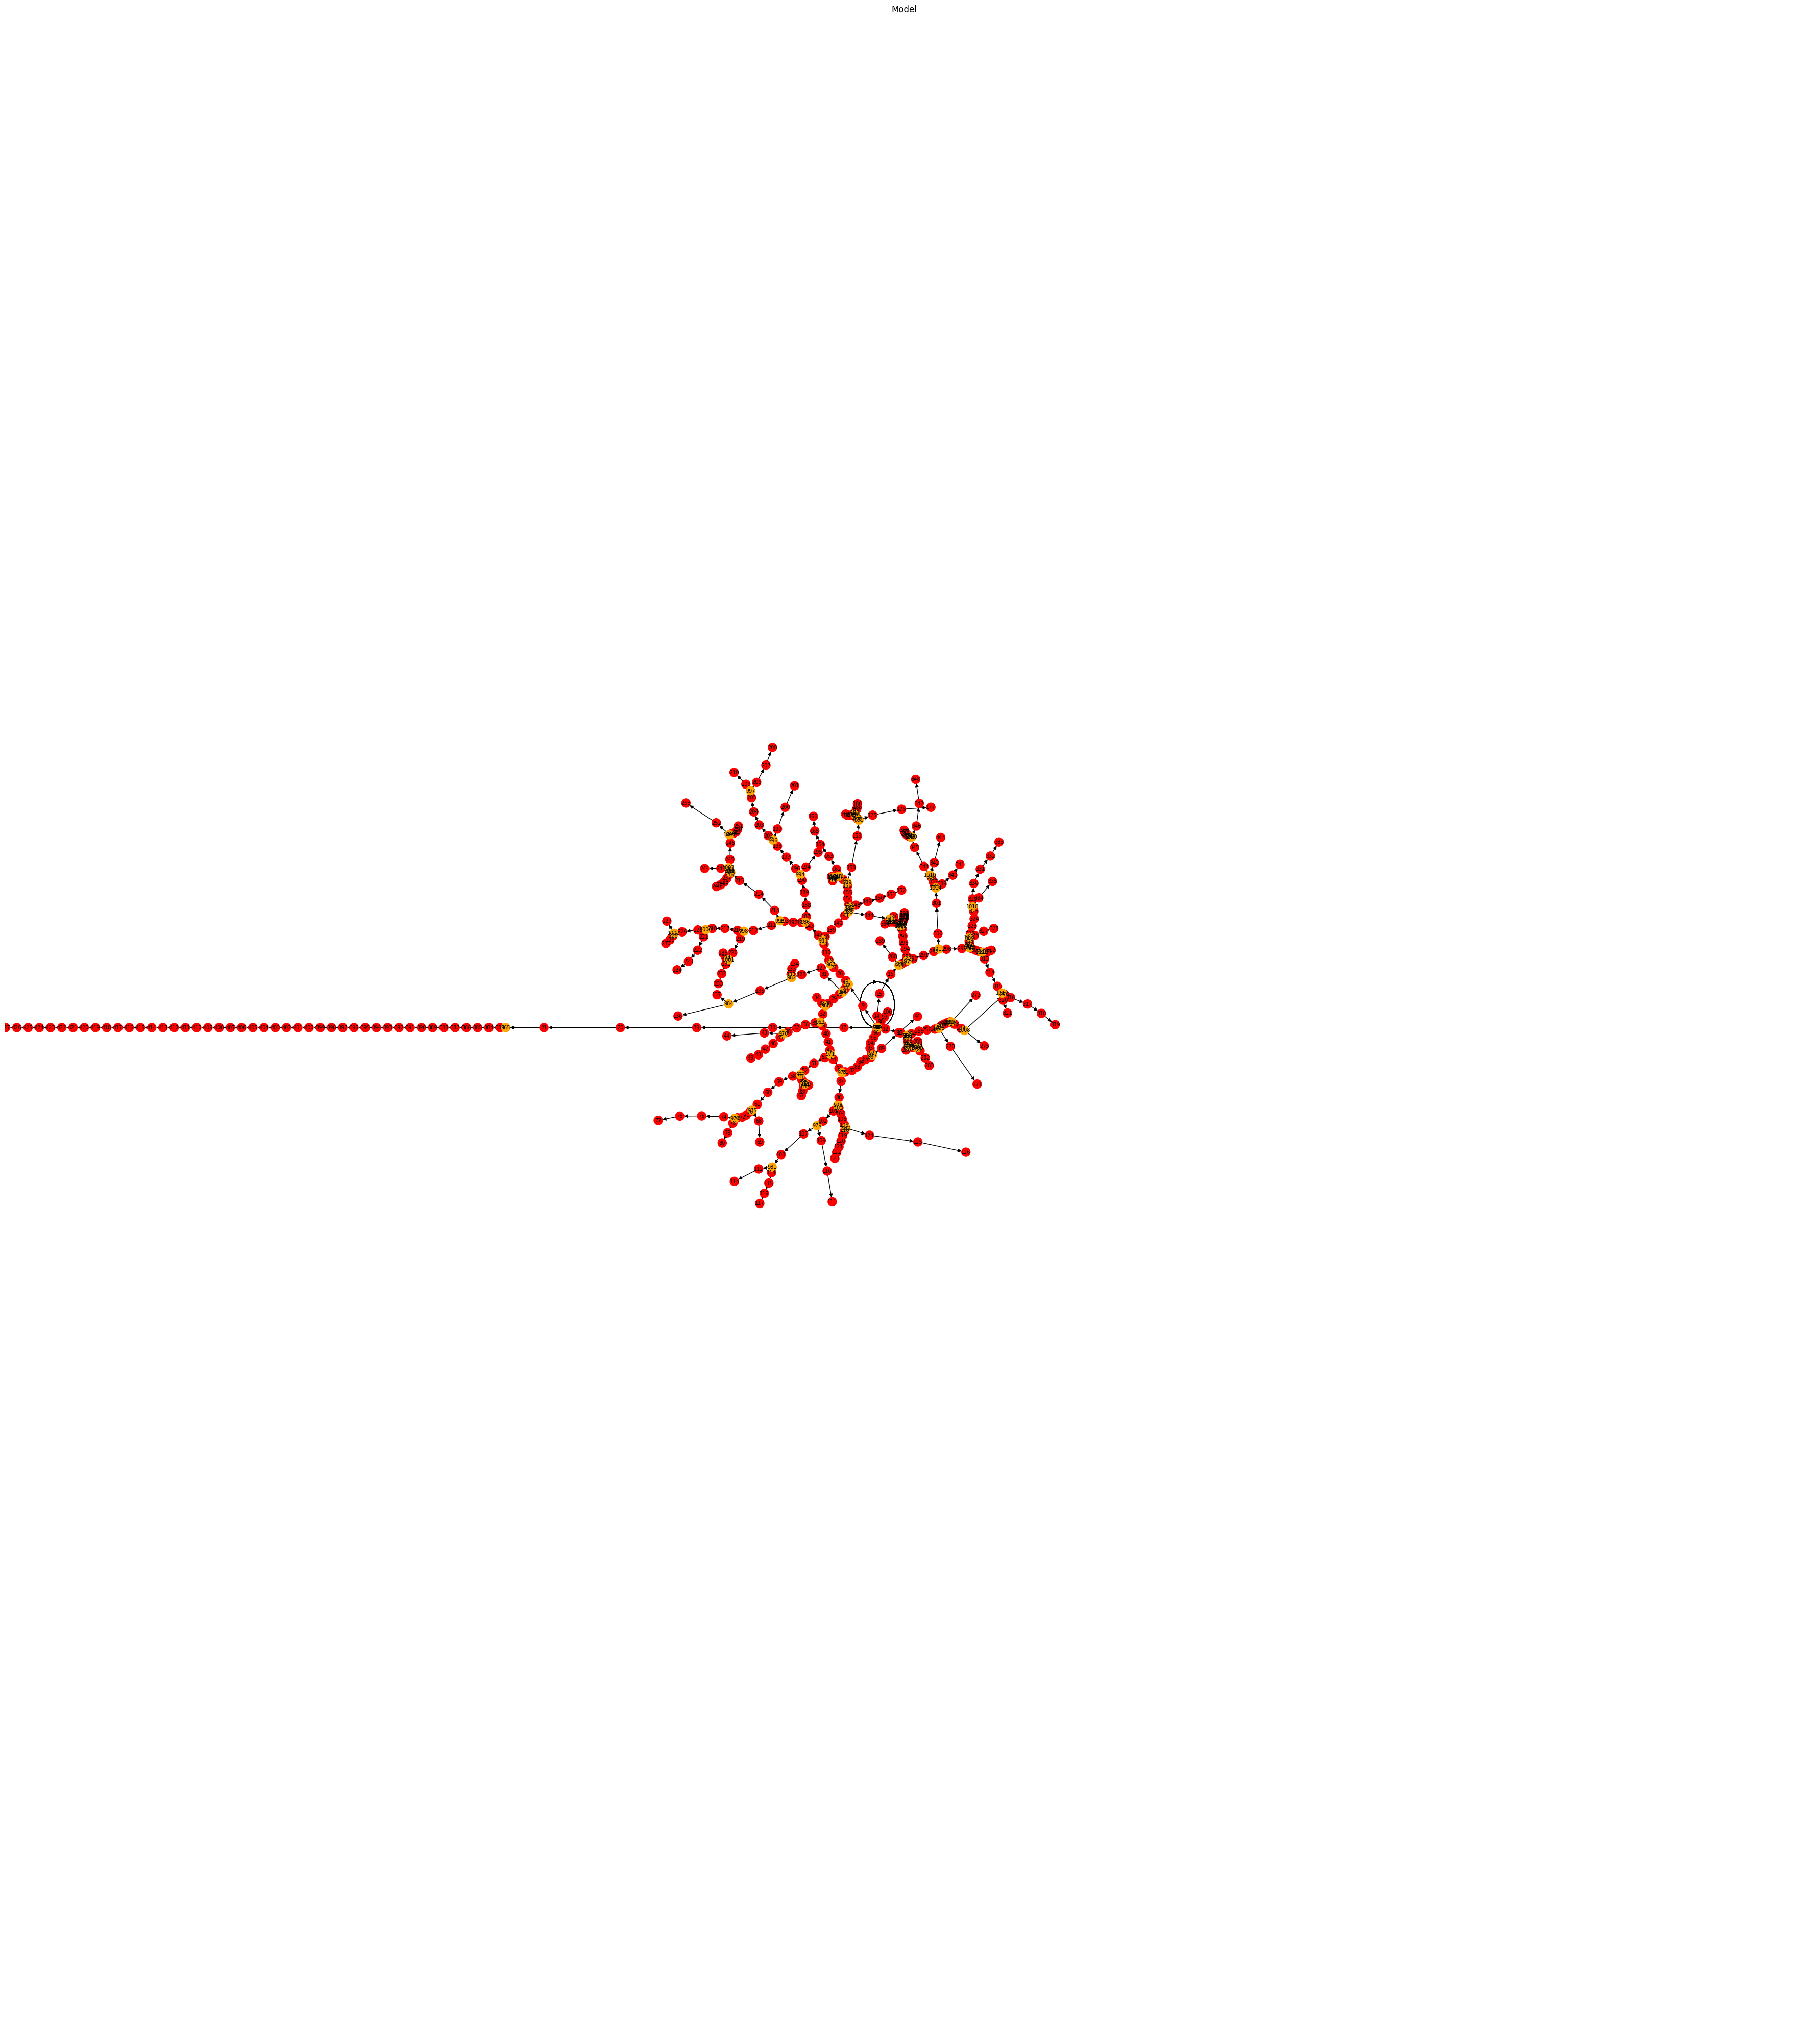

In [18]:
# plot electrode array using plt
fig = plt.figure(figsize=(100,100))

# side by side subplots

ax = fig.add_subplot(121)

from jaxley.modules.base import to_graph
from jaxley.io.graph import vis_compartment_graph
comp_graph = to_graph(cell)
vis_compartment_graph(comp_graph, ax=ax)

ax.set_aspect('equal')
ax.set_xlim([-400,400])
ax.set_ylim([-450,450])
# ax2.set_aspect('equal')
ax.set_title('Model')
# ax2.set_title('Real')
ax.set_xlabel('x [um]')
ax.set_ylabel('y [um]')
# ax2.set_xlabel('x [um]')
# ax2.set_ylabel('y [um]')
plt.show()

In [19]:
cell.delete_stimuli()

dt = 0.05  # ms
t_max = 10
time_vec = np.arange(0, t_max+dt, dt)
#current = jx.step_current(i_delay=1.0, i_dur=0.15, i_amp=0.1, delta_t=dt, t_max=t_max)
#cell.branch(0).comp(0).stimulate(current)

# Whatever is recorded will be returned by `jx.integrate()`. In this case,
# we record 8 compartments and voltage + 3 currents each. Therefore, `jx.integrate`
# will return a (8*4 x timesteps) array.
cell.record("v")
cell.record("i_HH")
cell.record("i_Ca")
cell.record("i_KCa")

true_outputs = jx.integrate(cell, t_max=t_max, delta_t=dt)
true_outputs = true_outputs.reshape(4, ncomps, -1)

Added 959 recordings. See `.recordings` for details.
Added 959 recordings. See `.recordings` for details.
Added 959 recordings. See `.recordings` for details.
Added 959 recordings. See `.recordings` for details.


In [24]:
print(true_outputs.shape)
print(true_outputs[1:].shape)

(4, 959, 201)
(3, 959, 201)


NameError: name 'current' is not defined

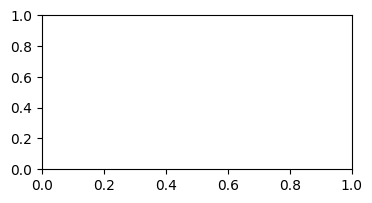

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = plt.plot(time_vec, current)

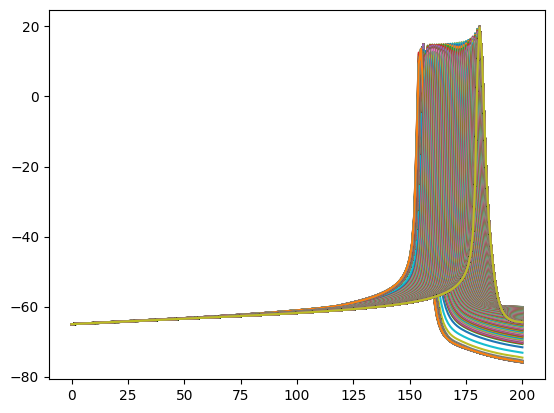

In [ ]:
for i in range(1, ncomps+1):
  plt.plot(true_outputs[0, i, :])

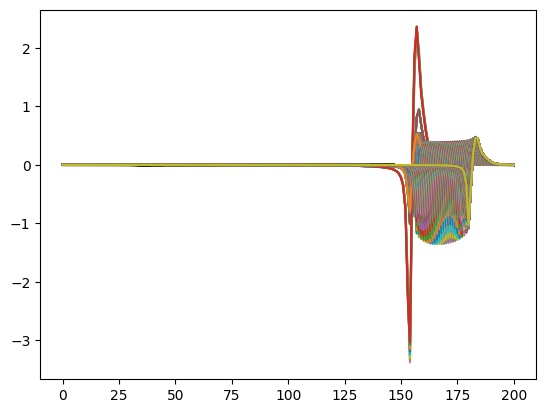

In [25]:
for i in range(1, ncomps+1):
  plt.plot(true_outputs[1, i, :])

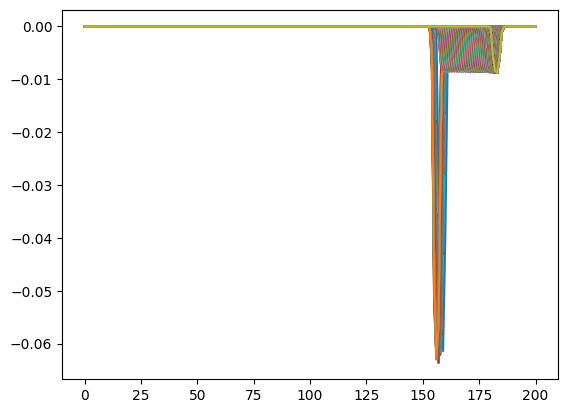

In [26]:
for i in range(1, ncomps+1):
  plt.plot(true_outputs[2, i, :])

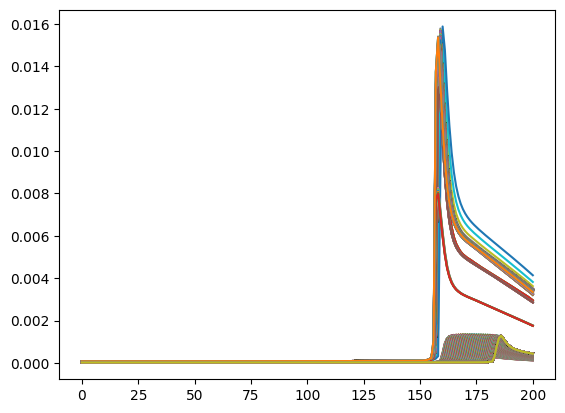

In [27]:
for i in range(1, ncomps+1):
  plt.plot(true_outputs[3, i, :])

In [47]:
# Create coordinate arrays
xx = LITKE_519_ARRAY_MAP[:, 0]
yy = LITKE_519_ARRAY_MAP[:, 1]
zz = -10*jnp.ones_like(xx)

# Stack and convert to jnp.array
grid = jnp.stack([xx, yy, zz], axis=-1)
n_points = grid.shape[0]

true_comp_positions = fh.compute_comp_xyz(cell)
true_distances = fh.distance(grid, true_comp_positions) # in um
true_distances_CM = true_distances * 10**(-4)

surf_areas = fh.get_surface_areas(cell)
surf_areas_CM2 = surf_areas * 10**(-8)

In [48]:
num_emissions = n_points
extr_voltage = fh.compute_eap(true_outputs, ncomps, surf_areas_CM2, true_distances_CM)

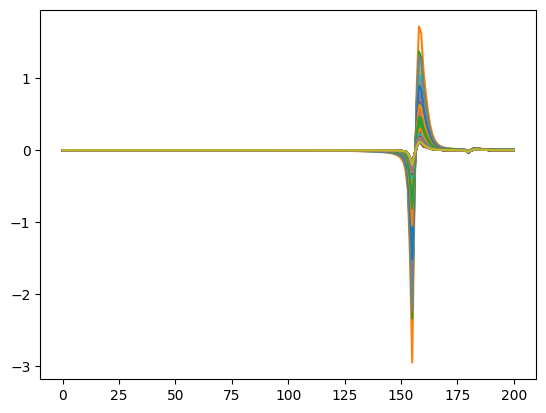

In [49]:
for i in range(n_points):
    plt.plot(extr_voltage[i, :])

Text(0, 0.5, 'y [um]')

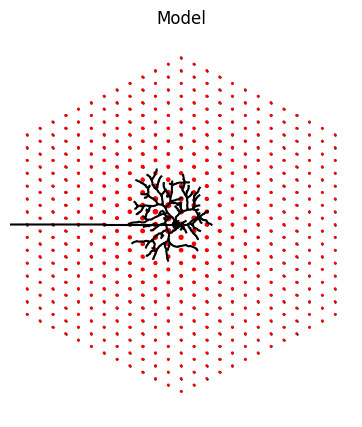

In [50]:
# Plot an example static EI

extr_voltage_fixed = fh.with_ttl(extr_voltage).T

fig, ax = plt.subplots(1, 1, figsize=(5,5))
fh.plot_static_ei_519(extr_voltage_fixed, ax=ax, title="Example Electrical Image")
cell.vis(ax=ax)
ax.set_aspect('equal')
ax.set_xlim([-400,400])
ax.set_ylim([-450,450])
# ax2.set_aspect('equal')
ax.set_title('Model')
# ax2.set_title('Real')
ax.set_xlabel('x [um]')
ax.set_ylabel('y [um]')
# ax2.set_xlabel('x [um]')
# ax2.set_ylabel('y [um]')

In [51]:
# Plot an example animated EI

anim = fh.animate_519_array(extr_voltage_fixed, title="Example Electrical Image", presentable=True)
HTML(fh._anim_to_html(anim, fps=10))